Now that you've learned about random forests and decision trees let's do an exercise in accuracy. You know that random forests are basically a collection of decision trees. But how do the accuracies of the two models compare?

So here's what you should do. Pick a dataset. It could be one you've worked with before or it could be a new one. Then build the best decision tree you can.

Now try to match that with the simplest random forest you can. For our purposes measure simplicity with runtime. Compare that to the runtime of the decision tree. This is imperfect but just go with it.

Hopefully out of this you'll see the power of random forests, but also their potential costs. Remember, in the real world you won't necessarily be dealing with thousands of rows. It could be millions, billions, or even more.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [60]:
# We import the data from csv file:
df = pd.read_csv('think capstone1_slim.csv' ,encoding ='latin1')


In [61]:
# Get a feel for the data:
df.head()

,YYYY_MM,IdProduct,Product_Name,Manufacturer_Name,Product Classification,IdLocation,Drugstore_Name,Total_Sales,No_of_transactions,No_of_medical_prescriptions,Units_Sold,Net_Profit,row_num_sales,row_num_profit
0,2015-1,20177,Nut Seringa Ject 10 Ml Cu Ac,MINUT,_DispozitivMedicalMultiplu,3,Stad,45.73,15,0,86.0,18.07,2,3
1,2015-1,2130,Panthen Unguent 50 Mg /G X 100 G,BAYER SCHERING,Cosmetice,3,Stad,265.55,4,0,5.0,46.66,1,1
2,2015-1,18,Oderma Abc Derm Gel Spumant X 200 Ml,BIODERMA,Cosmetice,3,Stad,37.42,1,0,1.0,9.45,14,9
3,2015-1,20697,Ltene Tratament Pt Unghii,FOLTENE,Cosmetice,3,Stad,48.90,1,0,1.0,4.38,8,33
4,2015-1,25030,Nsiprod Tensiometru Pentru Brat,PANSIPROD,Dispozitive Medicale,3,Stad,408.16,2,0,2.0,96.13,1,2


In [62]:
df=df.drop(['IdProduct','row_num_sales','row_num_profit','IdLocation','No_of_transactions'] , axis=1)

In [63]:
# What kind of data is in the dataframe?
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1686 entries, 0 to 1685
Data columns (total 9 columns):
YYYY_MM                        1686 non-null object
Product_Name                   1686 non-null object
Manufacturer_Name              1686 non-null object
Product Classification         1686 non-null object
Drugstore_Name                 1686 non-null object
Total_Sales                    1686 non-null float64
No_of_medical_prescriptions    1686 non-null int64
Units_Sold                     1686 non-null float64
Net_Profit                     1686 non-null float64
dtypes: float64(3), int64(1), object(5)
memory usage: 118.6+ KB
None


In [64]:
categorical = df.select_dtypes(include=['object'])
for i in categorical:
    column = categorical[i]
    print('Column name:',i ,' \t\t/ Unique values:', column.nunique())

Column name: YYYY_MM  		/ Unique values: 3
Column name: Product_Name  		/ Unique values: 488
Column name: Manufacturer_Name  		/ Unique values: 132
Column name: Product Classification  		/ Unique values: 12
Column name: Drugstore_Name  		/ Unique values: 5


In [9]:
# Instead of using this `pd.get_dummies(df)` with decission trees/random forest algorithms,
# I'll be better swithcing to 'Label Encoding'.
# Label encoding is simply converting each value in a column to a number. 

In [65]:
pd.options.mode.chained_assignment = None  # default='warn'
# The SettingWithCopyWarning was created to flag potentially confusing "chained" assignments, such as the following,
# which don't always work as expected, particularly when the first selection returns a copy. 

# or: You can set the is_copy flag to False, which will effectively turn off the check, *for that object``
# dfa.is_copy = False

In [66]:
categorical.head()

,YYYY_MM,Product_Name,Manufacturer_Name,Product Classification,Drugstore_Name
0,2015-1,Nut Seringa Ject 10 Ml Cu Ac,MINUT,_DispozitivMedicalMultiplu,Stad
1,2015-1,Panthen Unguent 50 Mg /G X 100 G,BAYER SCHERING,Cosmetice,Stad
2,2015-1,Oderma Abc Derm Gel Spumant X 200 Ml,BIODERMA,Cosmetice,Stad
3,2015-1,Ltene Tratament Pt Unghii,FOLTENE,Cosmetice,Stad
4,2015-1,Nsiprod Tensiometru Pentru Brat,PANSIPROD,Dispozitive Medicale,Stad


In [47]:
# Here I tried to automatically create numerical columns from categorical ones, but no success in two hours:

#for i in categorical:
#    #for j in range(len(categorical.columns)):
#    categorical[i] = categorical[i].astype('category').cat.codes
#    #categorical.concat
#categorical 
#
#or
#
#for i, df in enumerate(categorical, 1):
#    df.columns = [col_name+'_{}'.format(i) for col_name in df.columns]

In [67]:
# Change columns data types to 'category'. Couldn't do it automatically(see above):
categorical['YYYY_MM'] = categorical['YYYY_MM'].astype('category')
categorical['Product_Name'] = categorical['Product_Name'].astype('category')
categorical['Manufacturer_Name'] = categorical['Manufacturer_Name'].astype('category')
categorical['Product Classification'] = categorical['Product Classification'].astype('category')
categorical['Drugstore_Name'] = categorical['Drugstore_Name'].astype('category')

In [68]:
categorical.dtypes

YYYY_MM                   category
Product_Name              category
Manufacturer_Name         category
Product Classification    category
Drugstore_Name            category
dtype: object

In [70]:
categorical.head()

,YYYY_MM,Product_Name,Manufacturer_Name,Product Classification,Drugstore_Name
0,2015-1,Nut Seringa Ject 10 Ml Cu Ac,MINUT,_DispozitivMedicalMultiplu,Stad
1,2015-1,Panthen Unguent 50 Mg /G X 100 G,BAYER SCHERING,Cosmetice,Stad
2,2015-1,Oderma Abc Derm Gel Spumant X 200 Ml,BIODERMA,Cosmetice,Stad
3,2015-1,Ltene Tratament Pt Unghii,FOLTENE,Cosmetice,Stad
4,2015-1,Nsiprod Tensiometru Pentru Brat,PANSIPROD,Dispozitive Medicale,Stad


In [76]:
categorical["YYYY_MM_cat"] = categorical["YYYY_MM"].cat.codes
categorical["Product_Name_cat"] = categorical["Product_Name"].cat.codes
categorical["Manufacturer_Name_cat"] = categorical["Manufacturer_Name"].cat.codes
categorical["Product_Classification_cat"] = categorical["Product Classification"].cat.codes
categorical["Drugstore_Name_cat"] = categorical["Drugstore_Name"].cat.codes


In [78]:
categorical.head()

,YYYY_MM,Product_Name,Manufacturer_Name,Product Classification,Drugstore_Name,YYYY_MM_cat,Product_Name_cat,Manufacturer_Name_cat,Product_Classification_cat,Drugstore_Name_cat
0,2015-1,Nut Seringa Ject 10 Ml Cu Ac,MINUT,_DispozitivMedicalMultiplu,Stad,0,270,80,11,4
1,2015-1,Panthen Unguent 50 Mg /G X 100 G,BAYER SCHERING,Cosmetice,Stad,0,344,18,2,4
2,2015-1,Oderma Abc Derm Gel Spumant X 200 Ml,BIODERMA,Cosmetice,Stad,0,297,23,2,4
3,2015-1,Ltene Tratament Pt Unghii,FOLTENE,Cosmetice,Stad,0,196,55,2,4
4,2015-1,Nsiprod Tensiometru Pentru Brat,PANSIPROD,Dispozitive Medicale,Stad,0,241,89,3,4


In [85]:
categorical_cat = categorical.iloc[:,5:].copy()
categorical_cat.head()

,YYYY_MM_cat,Product_Name_cat,Manufacturer_Name_cat,Product_Classification_cat,Drugstore_Name_cat
0,0,270,80,11,4
1,0,344,18,2,4
2,0,297,23,2,4
3,0,196,55,2,4
4,0,241,89,3,4


In [92]:
# Extract the other numerical columns from the original data frame:
df_vals = df.iloc[:,5:].copy()

In [97]:
df_new = pd.concat([df_vals,categorical_cat], axis = 1 , ignore_index=False )
df_new.head()

,Total_Sales,No_of_medical_prescriptions,Units_Sold,Net_Profit,YYYY_MM_cat,Product_Name_cat,Manufacturer_Name_cat,Product_Classification_cat,Drugstore_Name_cat
0,45.73,0,86.0,18.07,0,270,80,11,4
1,265.55,0,5.0,46.66,0,344,18,2,4
2,37.42,0,1.0,9.45,0,297,23,2,4
3,48.90,0,1.0,4.38,0,196,55,2,4
4,408.16,0,2.0,96.13,0,241,89,3,4


# Decision Tree:

In [99]:
# This is the model we'll be using.
from sklearn import tree

In [98]:
X = df_new.drop('Net_Profit', axis=1)
Y = df_new['Net_Profit']
X = pd.get_dummies(X)
X = X.dropna(axis=1)

In [100]:
from sklearn.model_selection import train_test_split

# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=20)

print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)


(1348, 8) (1348,)
(338, 8) (338,)


In [101]:
from sklearn.tree import DecisionTreeRegressor
import numpy as np

import time
start_time = time.time()

regressor = DecisionTreeRegressor()
regressor.fit( X_train , y_train )

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.007019996643066406 seconds ---


In [104]:
# Calculate the coefficient of determination R2.
# It provides a measure of how well future samples are likely to be predicted by the model:
R2_val = regressor.score(X_test,y_test)
R2_val

0.8532726946712592

### To make predictions on the test set, use the predict method:

In [105]:
y_pred = regressor.predict(X_test) 


In [110]:
# Now let's compare some of our predicted values with the actual values and see how accurate we were:
df_compare=pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})  
df_compare.head()

,Actual,Predicted
1566,555.20,445.74
1569,203.11,175.52
799,765.17,921.52
1040,744.33,736.18
307,79.39,70.71


### Evaluating the Algorithm
To evaluate performance of the regression algorithm, the commonly used metrics are 
- mean absolute error, 
- mean squared error, and 
- root mean squared error. 

In [109]:
?metrics.mean_absolute_error(y_test, y_pred)

In [107]:
from sklearn import metrics  
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred))) 

Mean Absolute Error: 50.03076923076924
Mean Squared Error: 9798.550217159762
Root Mean Squared Error: 98.9876265861535


In [108]:
# Calculate the absolute errors
errors = abs(y_pred - y_test)

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 117.96 %.


### Overfitting ...?

### Cross validation for Decision Tree:

In [111]:
from sklearn.model_selection import cross_val_score

print(cross_val_score(regressor, X, Y, cv=10))

[0.79480488 0.84541995 0.93577088 0.89879038 0.63119802 0.89535974
 0.84290285 0.87340537 0.73077428 0.85909725]


### Random Forest

In [113]:
X = df_new.drop('Net_Profit', axis=1)
Y = df_new['Net_Profit']
X = pd.get_dummies(X)
X = X.dropna(axis=1)

In [114]:
from sklearn.model_selection import train_test_split

# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=20)

print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)


(1348, 8) (1348,)
(338, 8) (338,)


In [170]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

import time
start_time = time.time()

# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

# Train the model on training data
rf.fit(X_train, y_train);

print("--- %s seconds ---" % (time.time() - start_time))

--- 3.5257418155670166 seconds ---


In [171]:
col_names = X.columns
col_names

Index(['Total_Sales', 'No_of_medical_prescriptions', 'Units_Sold',
       'YYYY_MM_cat', 'Product_Name_cat', 'Manufacturer_Name_cat',
       'Product_Classification_cat', 'Drugstore_Name_cat'],
      dtype='object')

In [173]:
print ("Features sorted by their score:")
feat_importance = sorted(zip(col_names,map(lambda x: round(x, 4), rf.feature_importances_)), 
             reverse=True)

feat_importance[0:10]

Features sorted by their score:


[('YYYY_MM_cat', 0.0036),
 ('Units_Sold', 0.1169),
 ('Total_Sales', 0.6682),
 ('Product_Name_cat', 0.0494),
 ('Product_Classification_cat', 0.0219),
 ('No_of_medical_prescriptions', 0.0524),
 ('Manufacturer_Name_cat', 0.0781),
 ('Drugstore_Name_cat', 0.0095)]

In [179]:
feat_importance_df = pd.DataFrame(feat_importance, columns=['feature','importance'])
feat_importance_df = feat_importance_df.sort_values('importance',ascending=False).set_index('feature')
feat_importance_df

,importance
feature,
Total_Sales,0.6682
Units_Sold,0.1169
Manufacturer_Name_cat,0.0781
No_of_medical_prescriptions,0.0524
Product_Name_cat,0.0494
Product_Classification_cat,0.0219
Drugstore_Name_cat,0.0095
YYYY_MM_cat,0.0036


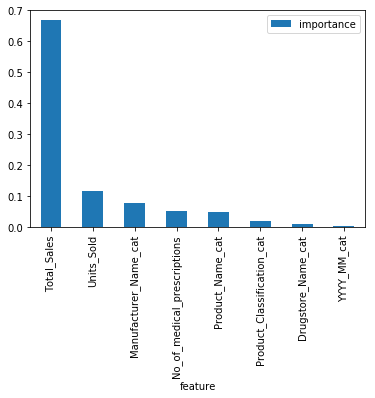

In [181]:
feat_importance_df.plot.bar()
plt.show()

### Make Predictions on the Test Set
We compare the predictions to the known answers. When performing regression, we need to make sure to use the absolute error because we expect some of our answers to be low and some to be high. We are interested in how far away our average prediction is from the actual value so we take the absolute value

In [118]:
# Use the forest's predict method on the test data
predictions = rf.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2 ), 'Net_Profit')

Mean Absolute Error: 39.45 Net_Profit


In [119]:
# R2:
rf.score(X_test , y_test)

0.9159727618869723

In [120]:
# Now let's compare some of our predicted values with the actual values and see how accurate we were:
df_compare=pd.DataFrame({'Actual':y_test, 'Predicted':predictions})  
df_compare

,Actual,Predicted
1566,555.20,534.66929
1569,203.11,250.31308
799,765.17,696.79268
1040,744.33,636.84603
307,79.39,83.70818
975,1485.84,1211.47305
996,32.04,15.38007
544,276.66,297.76105
460,95.54,206.84434
1155,10.74,11.16494


### Determine Performance Metrics
To put our predictions in perspective, we can calculate an accuracy using the mean average percentage error subtracted from 100 %.

In [144]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 304.7 %.


### You said that Accuracy should not be used,  isn't it?

### Cross Validation

In [146]:

from sklearn.model_selection import cross_val_score

import time
start_time = time.time()

rf_regr = RandomForestRegressor(random_state = 42)
X = df_new.drop('Net_Profit', axis=1)
Y = df_new['Net_Profit']
X = pd.get_dummies(X)
X = X.dropna(axis=1)

print(cross_val_score(rf_regr, X, Y, cv=10))


print("--- %s seconds ---" % (time.time() - start_time))

[0.856 0.91  0.922 0.928 0.906 0.908 0.931 0.889 0.807 0.887]
--- 0.38703107833862305 seconds ---


# Hyperparameter Tuning:

While model parameters are learned during training — such as the slope and intercept in a linear regression — hyperparameters must be set by the data scientist before training.

In [140]:
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf_regr.get_params())

Parameters currently in use:

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In the case of a random forest, the most important hyperparameters include:

- the number of trees in the forest (n_estimators) and 
- the number of features considered for splitting at each leaf node (max_features).

(The parameters of a random forest are the variables and thresholds used to split each node learned during training).

Hyperparameter tuning relies more on experimental results than theory, and thus the best method to determine the optimal settings is to try many different combinations evaluate the performance of each model. 

However, evaluating each model only on the training set can lead to one of the most fundamental problems in machine learning: <b>overfitting<b/>.
    
     the standard procedure for hyperparameter optimization accounts for overfitting through cross validation.

## SelectKbest

SelectKBest selects the top $k$ features that have maximum relevance with the target variable (they explain most of the variance). 

In [148]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

In [124]:
# feature extraction
kbest = SelectKBest(score_func=f_regression, k=5)

#Fitting finds the internal parameters of a model that will be used to transform data. 
fit = kbest.fit(X, Y)

# summarize scores
np.set_printoptions(precision=3)
print(fit.scores_[:10])

[1.627e+03 9.076e+02 1.032e+00 2.468e-02 3.080e-02 1.741e+00 5.573e+01
 7.871e+00]


In [125]:
#Transforming applies the parameters to data. You may fit a model to one set of data, and then 
#transform it on a completely different set.
features = fit.transform(X)
# summarize selected features
print(features[0:6,:])

[[ 45.73   0.    80.    11.     4.  ]
 [265.55   0.    18.     2.     4.  ]
 [ 37.42   0.    23.     2.     4.  ]
 [ 48.9    0.    55.     2.     4.  ]
 [408.16   0.    89.     3.     4.  ]
 [ 41.94   0.    38.     3.     4.  ]]


In [136]:
# In one step ???:
#selected_features = kbest.fit_transform(X, Y)

### Parameter Tuning in Scikit Learn using GridSearchCV:
- grid search cross validation

In [191]:
import numpy as np
from sklearn.grid_search import GridSearchCV

import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge


In [123]:
X = df.drop('Net_Profit', axis=1)
Y = df['Net_Profit']
X = pd.get_dummies(X)
X = X.dropna(axis=1)

In [124]:
# prepare a range of alpha values to test
alphas = np.array([1,0.1,0.01,0.001,0.0001,0])

In [125]:
# create and fit a ridge regression model, testing each alpha
model = Ridge()

By default, the GridSearchCV’s cross validation uses 3-fold KFold or StratifiedKFold depending on the situation.


In [192]:
# Create a based model
rf_estimator = RandomForestRegressor()

param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

In [193]:
grid = GridSearchCV(estimator = rf_estimator, param_grid = param_grid ,  n_jobs=-1, cv=5 ,verbose = 2)
grid.fit( X, Y )
print(grid)


Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   52.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  3.3min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'bootstrap': [True], 'max_depth': [80, 90, 100, 110], 'max_features': [2, 3], 'n_estimators': [100, 200, 300, 1000], 'min_samples_split': [8, 10, 12], 'min_samples_leaf': [3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=2)


In [194]:
# summarize the results of the grid search
print('best_score_: ',grid.best_score_)

best_score_:  0.8826089270750923


In [195]:
print('best_estimator_: ',grid.best_estimator_)

best_estimator_:  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=80,
           max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=3,
           min_samples_split=8, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)


In [197]:
grid.best_params_

{'bootstrap': True,
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 1000}

### Evaluation Function:

In [205]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} '.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%'.format(accuracy))

In [206]:
best_grid = grid.best_estimator_
evaluate(best_grid, X_test , y_test )

Model Performance
Average Error: 29.5719 
Accuracy = 254.71%
